# Klasifikace motýlů
4IT579 Praktické aplikace strojového učení<br>
Marie Geislerová<br>
30.1.2024<br>
<br>
#### Obsah:
1. Definice problému
2. Získání datasetu
3. Vizualizace a prozkoumání datasetu
4. Výběr metriky úspěchu a stanovení způsobu evaluace
5. Příprava dat
6. Výběr, příprava a trénování modelu
7. Vyladění modelu
8. Předtrénovaný model
9. Výsledky a závěr

## 1. Definice problému
Cílem práce je natrénovat model, který by byl schopný podle obrázku klasifikovat motýly a identifikovat třídu, do které patří.

Vstupní data: obrázky (RGB, budou převedeny na 180x180)<br>
Typ problému: 
- učení s učitelem (supervised learning), 
- klasifikace do více (exkluzivních) tříd

## 2. Získání datasetu
Odkaz na dataset: [00_dataset_butterfly](https://drive.google.com/drive/folders/15m3c1cZxPz0guKb6ruJCqY0rpj1ZMxpg?usp=sharing)

Dataset "00_dataset_butterfly" byl vytvořen z existujícího datasetu "Butterfly Image Classification" dostupného na kaggle.com, který jednotlivým motýlům na obrázku přiřazuje jejich třídu.
 
Dataset používaný v této práci obsahuje soubor "Training_set.csv" a složku "train". V dokumentaci originálního datasetu je uvedeno, že ve složce "train" jsou obrázky motýlů pojmenované ve formátu jpg. V souboru "Training_set.csv" jsou uvedeny 2 sloupce, jméno obrázku "filename" a třída "label", do které spadá motýl na tomto obrázku vyobrazený. Počet tříd je 75. Dataset obsahuje 6499 záznamů. Všechny záznamy jsou unikátní a nejsou zde žádné chybějící hodnoty.
 
 Originální dataset [Butterfly Image Classification - kaggle](https://www.kaggle.com/datasets/phucthaiv02/butterfly-image-classification?resource=download&select=Training_set.csv) obsahuje 2 složky "test" a "train", ve kterých se nachází obrázky motýlů, a 2 soubory "Testing_set.csv" a "Training_set.csv". Jelikož ale "Testing_set.csv" neobsahuje labely pro obrázky v "test", bude v této práci použit dataset, který neobsahuje "Testing_set.csv" a složku s obrázky "test".

## 3. Vizualizace a prozkoumání datasetu

In [ ]:
from tensorflow import keras
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os, shutil, random

r_seed = 38

In [2]:
# Paths to dataset
file = os.path.join("00_dataset_butterfly", "Training_set.csv")
dataset = pd.read_csv(file)

img_dir = os.path.join("00_dataset_butterfly", "train")

In [3]:
dataset.head()

,filename,label
0,Image_1.jpg,SOUTHERN DOGFACE
1,Image_2.jpg,ADONIS
2,Image_3.jpg,BROWN SIPROETA
3,Image_4.jpg,MONARCH
4,Image_5.jpg,GREEN CELLED CATTLEHEART


In [4]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6499 entries, 0 to 6498
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   filename  6499 non-null   object
 1   label     6499 non-null   object
dtypes: object(2)
memory usage: 101.7+ KB


In [5]:
dataset.groupby("label").describe()

filename                           
                             count unique            top freq
label                                                        
ADONIS                          88     88    Image_2.jpg    1
AFRICAN GIANT SWALLOWTAIL       75     75  Image_290.jpg    1
AMERICAN SNOOT                  74     74  Image_117.jpg    1
AN 88                           85     85  Image_123.jpg    1
APPOLLO                         90     90   Image_66.jpg    1
...                            ...    ...            ...  ...
ULYSES                          84     84  Image_125.jpg    1
VICEROY                         81     81   Image_63.jpg    1
WOOD SATYR                      71     71  Image_158.jpg    1
YELLOW SWALLOW TAIL             75     75  Image_204.jpg    1
ZEBRA LONG WING                 76     76  Image_157.jpg    1

[75 rows x 4 columns]

Dataset je nevyvážený
- nejméně zastoupená třída: WOOD SATYR - 71
- nejvíce zastoupená třída: MOURNING CLOAK - 131

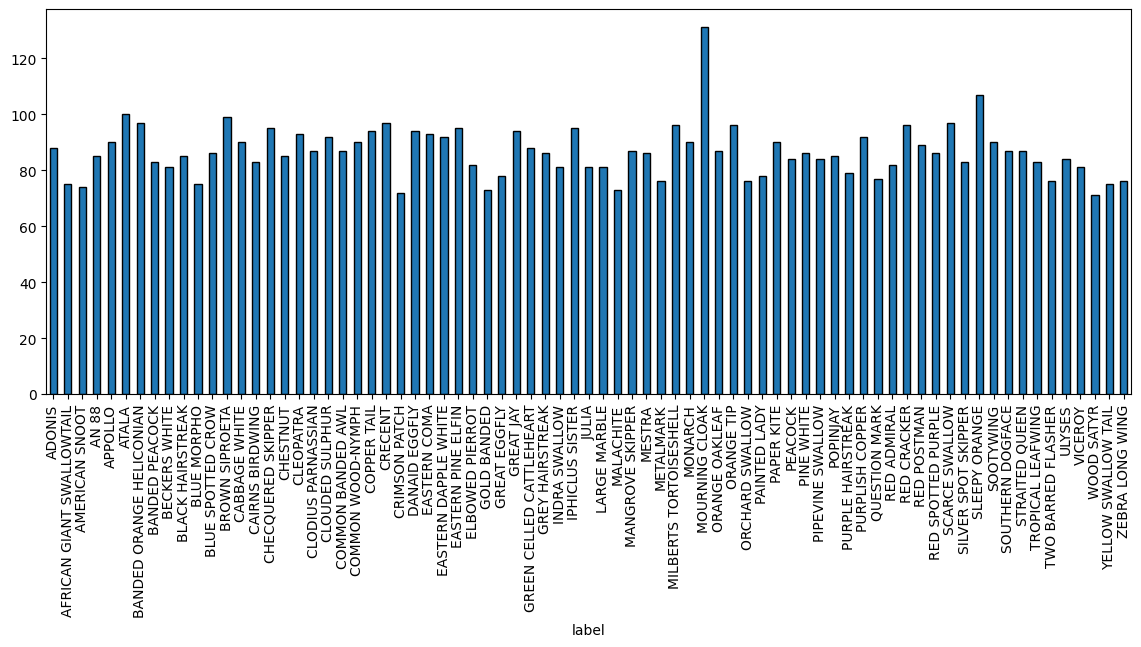

In [6]:
class_stats = dataset["label"].value_counts()
class_stats = class_stats.sort_index()
plt.figure(figsize=(14,5))
class_stats.plot(kind='bar', edgecolor='black')
plt.show()

In [7]:
example = os.path.join(img_dir, "Image_1.jpg")
mpimg.imread(example).shape

(224, 224, 3)

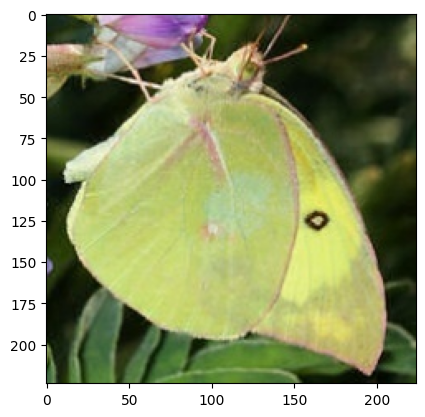

In [8]:
plt.imshow(mpimg.imread(example))

## 4. Výběr metriky úspěchu a stanovení způsobu evaluace

Metrika: **accuracy (správnost)** - podíl správných odpovědí

Máme úlohu klasifikace s větším počtem tříd. Všechny třídy jsou si rovny, není dána žádná větší priorita, nepovažuji tedy přesnost a úplnost za vhodné metriky. Proto byla zvolena správnost. 

Triviální klasifikátor by mohl vždy hádat pouze nejčastější třídu (= MOURNING CLOAK, 131), což by odpovídalo 
správnosti 131/6499 = 0.02 = **2 %**. Aby tedy nový klasifikátor přinesl nějakou hodnotu, musí mít minimálně lepší výsledek než správnost = 2 %.


Ztrátová funkce: **categorical_crossentropy** - během trénování měří jak si vede model tak, že porovnává predikované pravděpodobnosti se skutečnými labely.

## 5. Příprava dat
1) rozdělit obrázky do složek podle třídy, do které patří (dle "Training_set.csv")
2) z každé třídy vybrat náhodně určitou část obrázků rozdělit je takto:
    - trénovací dataset - cca 70 %
    - validační dataset - cca 15 %
    - testovací dataset - cca 15 %
3) předzpracovat obrázky

In [9]:
# 1) prepare dataset - sort images by classes into subdirectories (sometimes can take 1min 45s)

original_dir = img_dir
help_dir = os.path.join("00_dataset_butterfly", "train_sorted")
new_base_dir = os.path.join("00_dataset_butterfly", "train_prepared")

# sort images from original dataset into subdirs according to their classes
for index, row in dataset.iterrows():
    img_name = row['filename']
    class_label = str(row['label'])

    # Create class-specific directory if not exists
    class_directory = os.path.join(help_dir, class_label)
    os.makedirs(class_directory, exist_ok=True)

    # Copy image to class-specific directory
    shutil.copyfile(src= os.path.join(original_dir,img_name), dst=os.path.join(class_directory,img_name))

In [10]:
# 2) prepare dataset - prepare for preprocessing

def make_subset(subset_name, amount):
    for subdir in os.listdir(help_dir):
        subdir_path = os.path.join(help_dir, subdir)
        subdir_imgs = os.listdir(subdir_path)
        
        count = len(subdir_imgs)
        random.seed(r_seed)
        random.shuffle(subdir_imgs)
        limit = amount * count
        
        # move files to the destination directories
        for i, im in enumerate(subdir_imgs):
            if i >= limit:
                break
            im_from = os.path.join(subdir_path, im)            
            im_to = os.path.join(new_base_dir,subset_name, subdir)
            if not(os.path.exists(im_to)):
                os.makedirs(im_to)
            shutil.move(im_from, im_to)

if (os.path.exists(new_base_dir) != True):
    make_subset('train', 0.7) # 70 % of all images in subdirs
    make_subset('valid', 0.5) # 50 % of the remainder in subdirs
    make_subset('test', 1)    # the rest of the images in subdirs
    
shutil.rmtree(help_dir)

In [11]:
# 3) preprocessing

train_set = keras.preprocessing.image_dataset_from_directory(
                    os.path.join(new_base_dir, 'train'),
                    image_size=(180, 180),
                    batch_size=32,
                    label_mode='categorical',
                    #shuffle=False,
                    )

valid_set = keras.preprocessing.image_dataset_from_directory(
                    os.path.join(new_base_dir, 'valid'),
                    image_size=(180, 180),
                    batch_size=32,
                    label_mode='categorical',
                    #shuffle=False,
                    )

test_set = keras.preprocessing.image_dataset_from_directory(
                    os.path.join(new_base_dir, 'test'),
                    image_size=(180, 180),
                    batch_size=32,
                    label_mode='categorical',
                    #shuffle=False,
                    )

Found 4583 files belonging to 75 classes.
Found 976 files belonging to 75 classes.
Found 940 files belonging to 75 classes.


data batch shape: (32, 180, 180, 3)
labels batch shape: (32, 75)


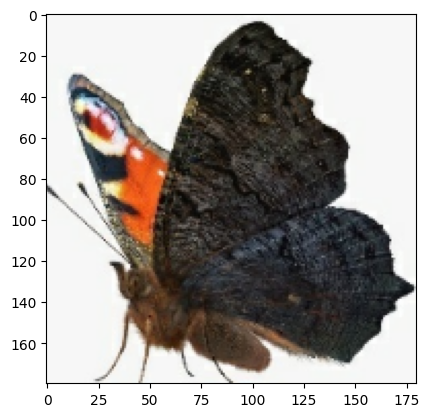

tf.Tensor(
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0.], shape=(75,), dtype=float32)


In [12]:
# visualization
for data_batch, labels_batch in train_set:
    print('data batch shape:', data_batch.shape)
    print('labels batch shape:', labels_batch.shape)
    
    for image, label in zip(data_batch, labels_batch):
        plt.imshow(image.numpy().astype('uint8'))
        plt.show()
        print(label)
        break # I really don't need to see soooo many butterflies
    break

## 6. Výběr, příprava a trénování modelu

#### MODEL 1

In [13]:
model1 = keras.models.Sequential([
    keras.layers.experimental.preprocessing.Rescaling(1./255, input_shape=(180,180,3)),
    
    keras.layers.Conv2D(16, 3, activation='relu'),
    keras.layers.MaxPooling2D(),
    
    keras.layers.Conv2D(32, 3, activation='relu'),
    keras.layers.MaxPooling2D(),
    
    keras.layers.Conv2D(64, 3, activation='relu'),
    keras.layers.MaxPooling2D(),
    
    keras.layers.Conv2D(128, 3, activation='relu'),
    keras.layers.MaxPooling2D(),
    
    keras.layers.Conv2D(256, 3, activation='relu'),
    
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(75, activation='softmax'),
])

In [14]:
model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 178, 178, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 89, 89, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 87, 87, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 43, 43, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 41, 41, 64)        1

In [15]:
model1.compile(loss='categorical_crossentropy', optimizer='sgd',
            metrics=['accuracy'])

In [16]:
# took me cca 45 min
early_stopping = keras.callbacks.EarlyStopping(patience=80)
checkpoint = keras.callbacks.ModelCheckpoint(filepath='00_model1_butterfly.keras',
                save_best_only=True, monitor='val_loss')

history = model1.fit(train_set,
                    epochs=80,
                    validation_data=valid_set,
                    callbacks=[checkpoint, early_stopping])

Epoch 1/80
144/144 [==============================] - 37s 242ms/step - loss: 4.3151 - accuracy: 0.0201 - val_loss: 4.3113 - val_accuracy: 0.0359
Epoch 2/80
144/144 [==============================] - 30s 208ms/step - loss: 4.3089 - accuracy: 0.0388 - val_loss: 4.3045 - val_accuracy: 0.0410
Epoch 3/80
144/144 [==============================] - 30s 205ms/step - loss: 4.2990 - accuracy: 0.0443 - val_loss: 4.2905 - val_accuracy: 0.0379
Epoch 4/80
144/144 [==============================] - 29s 203ms/step - loss: 4.2747 - accuracy: 0.0469 - val_loss: 4.2524 - val_accuracy: 0.0389
Epoch 5/80
144/144 [==============================] - 29s 199ms/step - loss: 4.1899 - accuracy: 0.0574 - val_loss: 4.1038 - val_accuracy: 0.0594
Epoch 6/80
144/144 [==============================] - 30s 204ms/step - loss: 3.9474 - accuracy: 0.0827 - val_loss: 3.7789 - val_accuracy: 0.0830
Epoch 7/80
144/144 [==============================] - 31s 214ms/step - loss: 3.5441 - accuracy: 0.1357 - val_loss: 3.8538 - val_ac

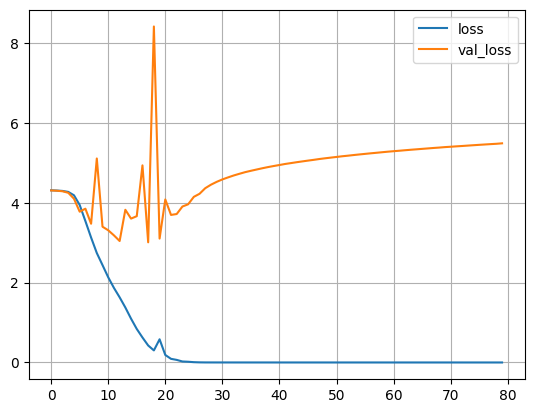

In [17]:
pd.DataFrame(history.history)[['loss', 'val_loss']].plot()
plt.grid(True)

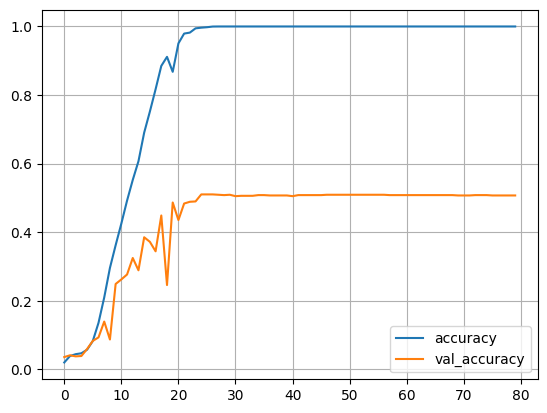

In [18]:
pd.DataFrame(history.history)[['accuracy', 'val_accuracy']].plot()
plt.grid(True)

##### Průběh na testovacím datasetu

In [19]:
model1 = keras.models.load_model('00_model1_butterfly.keras')

In [20]:
model1.evaluate(test_set)

30/30 [==============================] - 3s 53ms/step - loss: 2.7151 - accuracy: 0.4787


[2.715064287185669, 0.478723406791687]

##### Predikce na 1 obrázku z třídy ADONIS (což je třída s indexem kategorie 0)

In [21]:
subdir_path = os.path.join(new_base_dir, "test", "ADONIS")
predict_image_name = os.listdir(subdir_path)[0]
predict_image_path = os.path.join(subdir_path, predict_image_name)

In [22]:
img = keras.preprocessing.image.load_img(predict_image_path, target_size=(180,180))
input_arr = keras.preprocessing.image.img_to_array(img)
input_arr = np.array([input_arr])
input_arr.shape

(1, 180, 180, 3)

In [23]:
prediction = model1.predict(input_arr)
prediction

1/1 [==============================] - 0s 160ms/step


array([[4.7496772e-01, 4.5962710e-07, 1.0208457e-05, 1.1054620e-05,
        6.6782042e-05, 1.8132298e-05, 1.5362205e-06, 1.7615274e-06,
        1.3288119e-05, 5.1101096e-10, 7.0074372e-02, 9.5565294e-05,
        4.1546582e-07, 1.0024158e-06, 4.0439950e-06, 2.3225567e-08,
        5.6776946e-05, 5.6941326e-06, 9.2121266e-04, 2.1360624e-09,
        7.3662156e-04, 6.0888051e-06, 1.0067775e-05, 2.3965679e-10,
        1.6369334e-08, 7.0859051e-07, 2.0278529e-05, 8.2306266e-05,
        1.5855002e-07, 8.8877196e-06, 4.7807470e-07, 8.8322531e-07,
        1.1998476e-03, 7.6229320e-05, 4.9487908e-06, 1.9782010e-05,
        1.9863445e-07, 4.4122114e-10, 6.2898957e-06, 7.5037718e-08,
        1.6761070e-02, 1.7189684e-06, 8.2753869e-03, 1.3912070e-08,
        8.3439950e-08, 1.1226005e-09, 2.9538971e-04, 4.9522151e-07,
        4.5026559e-06, 4.0855056e-07, 1.1738199e-04, 1.1814858e-08,
        4.6568573e-02, 2.0731564e-05, 3.4987484e-06, 1.6239016e-01,
        1.9173711e-05, 1.1200960e-09, 3.6986375e

In [24]:
# predikovaný výsledek
np.argmax(prediction)

0

## 7. Vyladění modelu

#### MODEL 2

In [25]:
model2 = keras.models.Sequential([
    # data augmentation
    keras.layers.experimental.preprocessing.RandomFlip("horizontal"),
    keras.layers.experimental.preprocessing.RandomFlip("vertical"),
    keras.layers.experimental.preprocessing.RandomRotation(1.2),
    keras.layers.experimental.preprocessing.RandomZoom(0.2),

    keras.layers.experimental.preprocessing.Rescaling(1./255, input_shape=(180,180,3)),
    
    keras.layers.Conv2D(16, 3, activation='relu'),
    keras.layers.MaxPooling2D(),
    keras.layers.Dropout(0.4),
    
    keras.layers.Conv2D(32, 3, activation='relu'),
    keras.layers.MaxPooling2D(),
    keras.layers.Dropout(0.4),
    
    keras.layers.Conv2D(64, 3, activation='relu'),
    keras.layers.MaxPooling2D(),
    keras.layers.Dropout(0.4),
    
    keras.layers.Conv2D(128, 3, activation='relu'),
    keras.layers.MaxPooling2D(),
    
    keras.layers.Conv2D(256, 3, activation='relu'),
    
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(75, activation='softmax'),
])

In [26]:
model2.compile(loss='categorical_crossentropy', optimizer='sgd',
            metrics=['accuracy'])

In [27]:
# took me cca 45 min
early_stopping = keras.callbacks.EarlyStopping(patience=80)
checkpoint = keras.callbacks.ModelCheckpoint(filepath='00_model2_butterfly.keras',
                save_best_only=True, monitor='val_loss')

history = model2.fit(train_set,
                    epochs=80,
                    validation_data=valid_set,
                    callbacks=[checkpoint, early_stopping])

Epoch 1/80
144/144 [==============================] - 35s 235ms/step - loss: 4.3099 - accuracy: 0.0181 - val_loss: 4.3118 - val_accuracy: 0.0348
Epoch 2/80
144/144 [==============================] - 36s 246ms/step - loss: 4.2795 - accuracy: 0.0316 - val_loss: 4.2959 - val_accuracy: 0.0348
Epoch 3/80
144/144 [==============================] - 35s 239ms/step - loss: 4.2111 - accuracy: 0.0343 - val_loss: 4.2504 - val_accuracy: 0.0379
Epoch 4/80
144/144 [==============================] - 34s 233ms/step - loss: 4.1240 - accuracy: 0.0332 - val_loss: 4.1790 - val_accuracy: 0.0400
Epoch 5/80
144/144 [==============================] - 34s 234ms/step - loss: 4.0657 - accuracy: 0.0373 - val_loss: 4.1432 - val_accuracy: 0.0615
Epoch 6/80
144/144 [==============================] - 35s 239ms/step - loss: 4.0050 - accuracy: 0.0430 - val_loss: 4.0918 - val_accuracy: 0.0461
Epoch 7/80
144/144 [==============================] - 34s 234ms/step - loss: 3.9257 - accuracy: 0.0626 - val_loss: 4.0357 - val_ac

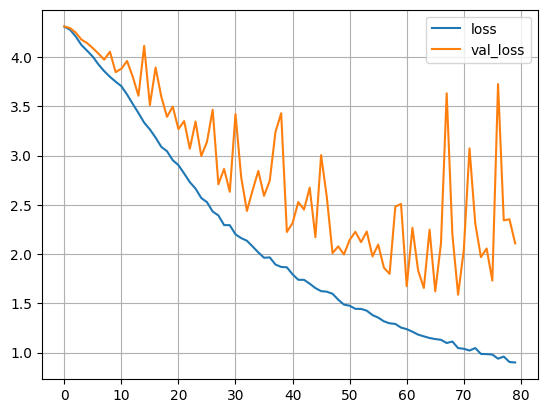

In [29]:
pd.DataFrame(history.history)[['loss', 'val_loss']].plot()
plt.grid(True)

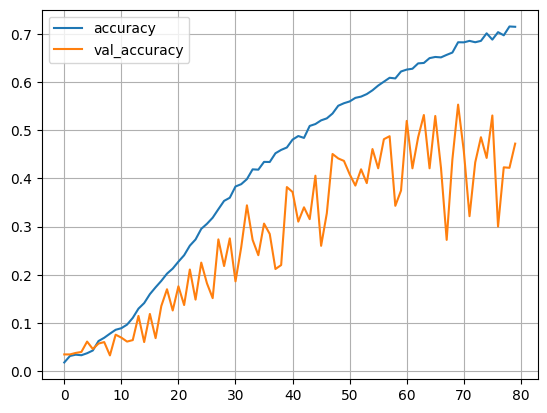

In [30]:
pd.DataFrame(history.history)[['accuracy', 'val_accuracy']].plot()
plt.grid(True)

##### Průběh na testovacím datasetu

In [31]:
model2 = keras.models.load_model('00_model2_butterfly.keras')

In [32]:
model2.evaluate(test_set)

30/30 [==============================] - 2s 51ms/step - loss: 1.5700 - accuracy: 0.5532


[1.569960594177246, 0.5531914830207825]

##### Predikce na 1 obrázku z třídy ADONIS (což je třída s indexem kategorie 0)

In [33]:
subdir_path = os.path.join(new_base_dir, "test", "ADONIS")
predict_image_name = os.listdir(subdir_path)[0]
predict_image_path = os.path.join(subdir_path, predict_image_name)

In [34]:
img = keras.preprocessing.image.load_img(predict_image_path, target_size=(180, 180))
input_arr = keras.preprocessing.image.img_to_array(img)
input_arr = np.array([input_arr])

In [35]:
prediction = model2.predict(input_arr)
prediction

1/1 [==============================] - 0s 90ms/step


array([[7.87252188e-01, 1.08870612e-04, 1.00495236e-03, 6.75824517e-03,
        8.62917572e-04, 1.18517382e-05, 1.95371194e-05, 7.04974764e-06,
        1.08808763e-01, 8.05070813e-05, 1.36027876e-02, 4.20722907e-04,
        7.19534228e-06, 1.66455720e-04, 1.06762373e-05, 2.43599538e-06,
        7.05612911e-05, 5.30086763e-05, 5.07184421e-04, 1.04584593e-04,
        8.38786218e-06, 5.26023496e-06, 4.23675694e-04, 1.97928639e-05,
        1.16648403e-06, 1.11933495e-07, 2.35567472e-06, 1.59644196e-03,
        5.88025023e-06, 1.80920472e-06, 5.64266171e-04, 3.23534823e-06,
        9.13614698e-04, 3.16664796e-07, 1.03094452e-03, 6.40488215e-05,
        1.90678784e-05, 2.91941410e-06, 9.10562056e-04, 1.63075747e-04,
        1.16575963e-03, 8.07071774e-05, 7.05135579e-04, 6.90265879e-05,
        7.48832917e-07, 6.98075155e-06, 5.59853343e-03, 1.25832879e-03,
        1.34022135e-04, 3.13511788e-04, 2.89765565e-04, 3.35347494e-07,
        1.80459779e-03, 3.07394448e-03, 5.13410532e-06, 1.936157

In [36]:
# predikovaný výsledek
np.argmax(prediction)

0

## 8. Předtrénovaný model
Extrakce příznaků - použije se konvoluční báze z modelu a výstup pak pokračuje do nového klasifikátoru

In [37]:
# vgg16
conv_base = keras.applications.vgg16.VGG16(weights='imagenet', 
                                           include_top=False,
                                           input_shape=(180, 180, 3))

In [38]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 180, 180, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 180, 180, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 90, 90, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 90, 90, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 90, 90, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 45, 45, 128)       0     

In [39]:
# took me cca 9 mins
def get_features_and_labels(dataset_categ):
    all_features = []
    all_labels = []
    
    for images, labels in dataset_categ:
        preprocessed_images = keras.applications.vgg16.preprocess_input(images)
        features = conv_base.predict(preprocessed_images)
        all_features.append(features)
        all_labels.append(labels)
        
    return np.concatenate(all_features), np.concatenate(all_labels)

train_features, train_labels = get_features_and_labels(train_set)
valid_features, valid_labels = get_features_and_labels(valid_set)
test_features, test_labels = get_features_and_labels(test_set)

1/1 [==============================] - 1s 1s/step


In [40]:
train_features.shape

(4583, 5, 5, 512)

In [41]:
model3 = keras.models.Sequential([
    keras.layers.Flatten(input_shape=train_features.shape[1:]),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(75, activation='softmax'),
])

In [42]:
model3.compile(loss='categorical_crossentropy', optimizer='sgd',
            metrics=['accuracy'])

In [43]:
# took me cca 2 min
early_stopping = keras.callbacks.EarlyStopping(patience=80)
checkpoint = keras.callbacks.ModelCheckpoint(filepath='00_model3_butterfly.keras',
                save_best_only=True, monitor='val_loss')

history = model3.fit(train_features, train_labels,
                    epochs=80,
                    validation_data=(valid_features, valid_labels),
                    callbacks=[checkpoint, early_stopping])

Epoch 1/80
144/144 [==============================] - 1s 7ms/step - loss: 33.5020 - accuracy: 0.0478 - val_loss: 4.3402 - val_accuracy: 0.0768
Epoch 2/80
144/144 [==============================] - 1s 7ms/step - loss: 4.0893 - accuracy: 0.0781 - val_loss: 4.0910 - val_accuracy: 0.0727
Epoch 3/80
144/144 [==============================] - 1s 7ms/step - loss: 3.9679 - accuracy: 0.1023 - val_loss: 3.9802 - val_accuracy: 0.0953
Epoch 4/80
144/144 [==============================] - 1s 7ms/step - loss: 3.8959 - accuracy: 0.1111 - val_loss: 3.8984 - val_accuracy: 0.1127
Epoch 5/80
144/144 [==============================] - 1s 7ms/step - loss: 3.8134 - accuracy: 0.1292 - val_loss: 3.8428 - val_accuracy: 0.1332
Epoch 6/80
144/144 [==============================] - 1s 7ms/step - loss: 3.7670 - accuracy: 0.1410 - val_loss: 3.7619 - val_accuracy: 0.1383
Epoch 7/80
144/144 [==============================] - 1s 5ms/step - loss: 3.7509 - accuracy: 0.1429 - val_loss: 3.9314 - val_accuracy: 0.1342
Epoch

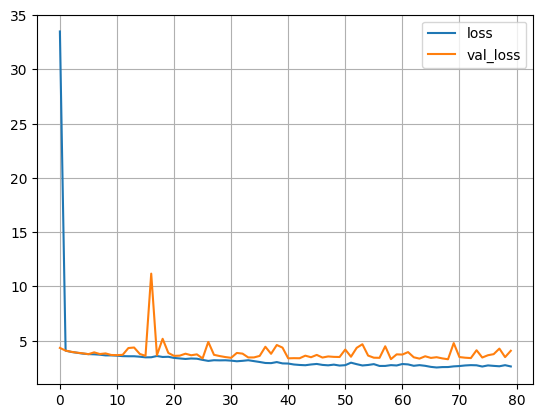

In [44]:
pd.DataFrame(history.history)[['loss', 'val_loss']].plot()
plt.grid(True)

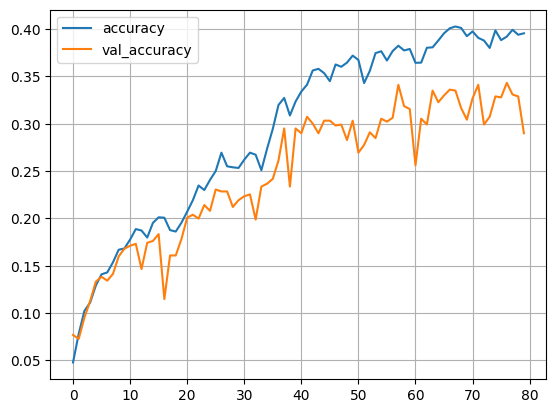

In [45]:
pd.DataFrame(history.history)[['accuracy', 'val_accuracy']].plot()
plt.grid(True)

##### Průběh na testovacím datasetu

In [46]:
model3 = keras.models.load_model('00_model3_butterfly.keras')

In [47]:
model3.evaluate(test_features, test_labels)

30/30 [==============================] - 1s 7ms/step - loss: 3.6177 - accuracy: 0.3298


[3.6177239418029785, 0.3297872245311737]

##### Predikce na 1 obrázku z třídy ADONIS (což je třída s indexem kategorie 0)

In [48]:
subdir_path = os.path.join(new_base_dir, "test", "ADONIS")
predict_image_name = os.listdir(subdir_path)[0]
predict_image_path = os.path.join(subdir_path, predict_image_name)

In [49]:
img = keras.preprocessing.image.load_img(predict_image_path, target_size=(180, 180))
input_arr = keras.preprocessing.image.img_to_array(img)
input_arr = np.array([input_arr])
input_arr.shape

(1, 180, 180, 3)

In [50]:
prediction = model1.predict(input_arr)
prediction

1/1 [==============================] - 0s 80ms/step


array([[4.7496772e-01, 4.5962710e-07, 1.0208457e-05, 1.1054620e-05,
        6.6782042e-05, 1.8132298e-05, 1.5362205e-06, 1.7615274e-06,
        1.3288119e-05, 5.1101096e-10, 7.0074372e-02, 9.5565294e-05,
        4.1546582e-07, 1.0024158e-06, 4.0439950e-06, 2.3225567e-08,
        5.6776946e-05, 5.6941326e-06, 9.2121266e-04, 2.1360624e-09,
        7.3662156e-04, 6.0888051e-06, 1.0067775e-05, 2.3965679e-10,
        1.6369334e-08, 7.0859051e-07, 2.0278529e-05, 8.2306266e-05,
        1.5855002e-07, 8.8877196e-06, 4.7807470e-07, 8.8322531e-07,
        1.1998476e-03, 7.6229320e-05, 4.9487908e-06, 1.9782010e-05,
        1.9863445e-07, 4.4122114e-10, 6.2898957e-06, 7.5037718e-08,
        1.6761070e-02, 1.7189684e-06, 8.2753869e-03, 1.3912070e-08,
        8.3439950e-08, 1.1226005e-09, 2.9538971e-04, 4.9522151e-07,
        4.5026559e-06, 4.0855056e-07, 1.1738199e-04, 1.1814858e-08,
        4.6568573e-02, 2.0731564e-05, 3.4987484e-06, 1.6239016e-01,
        1.9173711e-05, 1.1200960e-09, 3.6986375e

In [51]:
# predikovaný výsledek
np.argmax(prediction)

0

## 9. Výsledky a závěr
Výsledky jednotlivých modelů na testovacím datasetu jsou následující:
<br>

|         VÝSLEDKY          |        loss        | accuracy |
|:-------------------------:|:------------------:| :-: |
|          model1:          | 2.715064287185669  | 0.478723406791687 |
|          model2:          | 1.569960594177246  |  0.5531914830207825 |
|          model3:          | 3.6177239418029785 | 0.3297872245311737 |

<br>

V rámci této práce dosáhl nejlepšího výsledku model2, tedy vlastní model s využitím data augmentation a dropout. Dosáhl správnosti (accuracy) 55,3 %, což je lepší výsledek než stanovená hranice 2 %, kterých by dosáhl triviální klasifikátor. Ovšem všechny modely v této práci by tento výsledek překonaly.

Dalšího zlepšení modelu 2 by se mohlo zkusit dosáhnout experimentováním s learning rate a dále zkoušet upravovat hyperparametry.

U předtrénovaného modelu 3 by stálo za zkoušku ho nechat běžet déle a případně zkusit přidat další vrstvy a neurony do nově připravené části modelu.

Zlepšení výsledků všech modelů by určitě přineslo zvětšení datasetu.